# Import Libraries

In [ ]:
from __future__ import annotations

import os
import time
import copy
from dataclasses import dataclass
from typing import Dict, Any, Optional, Tuple, List

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from transformers import AutoTokenizer, AutoModel

# Mount Google Drive

In [ ]:
try:
    from google.colab import drive

    DRIVE_MOUNT_PATH = "/content/drive"
    drive.mount(DRIVE_MOUNT_PATH)
except Exception:
    print("Not running in Google Colab or Drive mount not available.")

Mounted at /content/drive


# Configurations

In [ ]:
# Config
@dataclass
class Config:
    images_dir: str = (
        "/content/drive/MyDrive/nn dataset/images/images_normalized"
    )
    reports_file: str = "/content/drive/MyDrive/nn dataset/indiana_reports.csv"
    projections_file: str = (
        "/content/drive/MyDrive/nn dataset/indiana_projections.csv"
    )

    batch_size: int = 16
    max_len: int = 256
    num_classes: int = 2

    lr_frozen: float = 1e-4
    lr_unfrozen: float = 1e-5

    epochs: int = 20
    patience: int = 5
    unfreeze_epoch: int = 4  # unfreeze AFTER epoch index 4 (i.e., after 5th epoch)

    model_save_path: str = (
        "/content/drive/MyDrive/final_best_multimodal_xray.pth"
    )
    random_state: int = 42


CFG = Config()

# Utilities

In [ ]:
# Utilities
def clean_text(text: str) -> str:
    """
    Clean text to reduce label leakage (remove explicit label words).
    """
    text = (text or "").lower()
    for word in ["normal", "abnormal", "unremarkable"]:
        text = text.replace(word, "")
    return text.strip()


def safe_open_image(path: str) -> Optional[Image.Image]:
    """
    Safely open an image and convert to RGB. Returns None if it fails.
    """
    try:
        img = Image.open(path).convert("RGB")
        return img
    except Exception:
        return None


def get_device() -> torch.device:
    """
    Select CUDA if available, else CPU.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [ ]:
# Data Loading
def load_and_prepare_dataframe(
    reports_file: str,
    projections_file: str,
    images_dir: str,
) -> pd.DataFrame:
    """
    Load projections and reports CSVs, merge, filter frontal views, build text,
    and create binary labels based on report text.
    """
    reports_df = pd.read_csv(reports_file)
    projections_df = pd.read_csv(projections_file)

    data = projections_df.merge(reports_df, on="uid", how="inner")

    # Use frontal projection only
    data = data[data["projection"] == "Frontal"].copy()

    # Build image path
    # Some datasets have filenames like "CXR123.png" stored in projections.
    if "filename" in data.columns:
        data["image_path"] = data["filename"].apply(
            lambda x: os.path.join(images_dir, str(x))
        )
    elif "image_path" not in data.columns:
        raise ValueError(
            "Could not find 'filename' or 'image_path' column to locate images."
        )

    # Combine findings + impression
    data["combined_text"] = (
        data["findings"].fillna("") + " " + data["impression"].fillna("")
    )

    # Binary label: 0 if "normal" appears, else 1
    data["label"] = data["combined_text"].apply(
        lambda x: 0 if "normal" in str(x).lower() else 1
    )

    # Clean text to remove label leakage
    data["combined_text"] = data["combined_text"].apply(clean_text)

    # Drop rows with missing image paths
    data = data.dropna(subset=["combined_text"]).reset_index(drop=True)

    return data

# Load Tokenizer

In [ ]:
def load_tokenizer() -> AutoTokenizer:
    """
    Load BioBERT tokenizer, fallback to bert-base-uncased if needed.
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    except Exception:
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    return tokenizer

# Dataset and Dataloader

In [ ]:
# Dataset & DataLoader
class ChestXRayMultimodalDataset(Dataset):
    """
    Dataset returning:
      - image tensor
      - tokenized text input_ids & attention_mask
      - label tensor
    """

    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_len: int = 256,
        transform: Optional[transforms.Compose] = None,
    ):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        row = self.df.iloc[idx]

        # Image
        image_path = str(row.get("image_path", ""))
        img = safe_open_image(image_path)
        if img is None:
            img_tensor = torch.zeros(3, 224, 224)
        else:
            img_tensor = self.transform(img) if self.transform else img

        # Text
        combined_text = str(row.get("combined_text", ""))
        encoding = self.tokenizer(
            combined_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        label = torch.tensor(int(row["label"]), dtype=torch.long)

        return {
            "image": img_tensor,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": label,
        }

In [ ]:
def build_transforms() -> transforms.Compose:
    """
    Image transform consistent with pretrained CNN expectations.
    """
    return transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )


def split_data(
    df: pd.DataFrame,
    random_state: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Train/val/test split: 70/15/15 with stratification.
    """
    train_df, temp_df = train_test_split(
        df,
        test_size=0.3,
        random_state=random_state,
        stratify=df["label"],
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=random_state,
        stratify=temp_df["label"],
    )
    return train_df, val_df, test_df

In [ ]:
def build_loaders(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    tokenizer: AutoTokenizer,
    image_transform: transforms.Compose,
    batch_size: int,
    max_len: int,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Build DataLoaders for train/val/test.
    """
    train_ds = ChestXRayMultimodalDataset(
        train_df,
        tokenizer,
        max_len=max_len,
        transform=image_transform,
    )
    val_ds = ChestXRayMultimodalDataset(
        val_df,
        tokenizer,
        max_len=max_len,
        transform=image_transform,
    )
    test_ds = ChestXRayMultimodalDataset(
        test_df,
        tokenizer,
        max_len=max_len,
        transform=image_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, val_loader, test_loader

# Multimodal Model

In [ ]:
# Multimodal Model
class MultimodalModel(nn.Module):
    """
    ResNet-18 image encoder + BioBERT text encoder + concatenation fusion.
    """

    def __init__(self, num_classes: int = 2):
        super().__init__()

        # Image branch
        self.cnn = models.resnet18(
            weights=models.ResNet18_Weights.DEFAULT
        )
        self.cnn.fc = nn.Identity()  # outputs 512-dim

        # Text branch
        self.transformer = AutoModel.from_pretrained(
            "dmis-lab/biobert-v1.1"
        )

        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(
        self,
        image: torch.Tensor,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> torch.Tensor:
        img_feat = self.cnn(image)
        text_out = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        txt_feat = text_out.pooler_output
        fused = torch.cat((img_feat, txt_feat), dim=1)
        logits = self.classifier(fused)
        return logits

# Model Train and Evaluation

In [ ]:
# Training and Evaluation
def compute_class_weights(train_df: pd.DataFrame) -> torch.Tensor:
    """
    Compute inverse-frequency class weights for CrossEntropyLoss.
    """
    class_counts = train_df["label"].value_counts().sort_index()
    weights = 1.0 / class_counts
    return torch.tensor(weights.values, dtype=torch.float)


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    """
    Train for one epoch.
    Returns epoch loss and accuracy.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for batch in tqdm(loader, desc="Training", leave=False):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += images.size(0)

    epoch_loss = running_loss / max(total, 1)
    epoch_acc = running_corrects / max(total, 1)
    return epoch_loss, float(epoch_acc)


def evaluate_loss_acc(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    """
    Evaluate loss and accuracy.
    """
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            val_loss += loss.item() * images.size(0)
            val_corrects += torch.sum(preds == labels).item()
            total += images.size(0)

    avg_loss = val_loss / max(total, 1)
    avg_acc = val_corrects / max(total, 1)
    return avg_loss, float(avg_acc)


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau,
    criterion: nn.Module,
    device: torch.device,
    epochs: int,
    patience: int,
    unfreeze_epoch: int,
    lr_unfrozen: float,
    save_path: str,
) -> nn.Module:
    """
    Train with early stopping and save best weights.
    """
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(epochs):
        epoch_start = time.time()

        train_loss, train_acc = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
        )

        val_loss, val_acc = evaluate_loss_acc(
            model=model,
            loader=val_loader,
            criterion=criterion,
            device=device,
        )

        scheduler.step(val_loss)

        elapsed = time.time() - epoch_start
        print(
            f"Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
            f"Time: {elapsed:.1f}s"
        )

        # Unfreeze BioBERT after specified epoch index
        if epoch == unfreeze_epoch:
            print("Unfreezing BioBERT for fine-tuning...")
            for param in model.transformer.parameters():
                param.requires_grad = True
            for group in optimizer.param_groups:
                group["lr"] = lr_unfrozen

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            torch.save(best_model_wts, save_path)
            print("Best model saved.")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model


def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> None:
    """
    Evaluate model: classification report, ROC-AUC, confusion matrix, ROC curve.
    """
    model.eval()
    y_true: List[int] = []
    y_pred: List[int] = []
    y_probs: List[float] = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images, input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy().tolist())
            y_probs.extend(probs.cpu().numpy().tolist())

    print("\nClassification Report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=["Normal", "Abnormal"],
        )
    )

    auc = roc_auc_score(y_true, y_probs)
    print(f"ROC–AUC: {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Abnormal"],
        yticklabels=["Normal", "Abnormal"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Gradio Inference App

In [ ]:
# Gradio Inference App
def build_gradio_app(
    model: nn.Module,
    tokenizer: AutoTokenizer,
    image_transform: transforms.Compose,
    device: torch.device,
):
    import gradio as gr

    def predict(input_image: Image.Image, input_text: str) -> Dict[str, float]:
        model.eval()

        img_tensor = image_transform(input_image).unsqueeze(0).to(device)

        if not input_text or input_text.strip() == "":
            input_text_local = "No clinical findings reported."
        else:
            input_text_local = input_text

        input_text_local = clean_text(input_text_local)

        encoding = tokenizer(
            input_text_local,
            padding="max_length",
            truncation=True,
            max_length=CFG.max_len,
            return_tensors="pt",
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(img_tensor, input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)[0]

        return {"Normal": float(probs[0]), "Abnormal": float(probs[1])}

    interface = gr.Interface(
        fn=predict,
        inputs=[
            gr.Image(type="pil", label="Upload Chest X-Ray"),
            gr.Textbox(
                lines=3,
                label="Clinical Report / Findings",
                placeholder="Enter findings here...",
            ),
        ],
        outputs=gr.Label(num_top_classes=2, label="Diagnostic Prediction"),
        title="Multimodal Chest X-Ray Diagnostic Assistant",
        description=(
            "ResNet-18 + BioBERT multimodal classifier for chest X-rays "
            "and clinical reports."
        ),
        theme="soft",
    )

    return interface

# Main Function

Using device: cuda
Loading data...
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded.
Building model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Training...


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Training:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.6346, Acc: 0.7796 | Val Loss: 0.5556, Acc: 0.8185 | Time: 1149.2s
Best model saved.


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.5014, Acc: 0.8619 | Val Loss: 0.6656, Acc: 0.7976 | Time: 241.1s


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e78cb1b6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e78cb1b6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/20 | Train Loss: 0.3290, Acc: 0.9296 | Val Loss: 0.8188, Acc: 0.7958 | Time: 235.8s


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1642, Acc: 0.9659 | Val Loss: 1.2974, Acc: 0.8133 | Time: 233.7s


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.0418, Acc: 0.9899 | Val Loss: 1.7028, Acc: 0.8831 | Time: 236.4s
Unfreezing BioBERT for fine-tuning...


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0067, Acc: 0.9985 | Val Loss: 1.9620, Acc: 0.8866 | Time: 276.4s
Early stopping triggered.

Evaluating on test set...


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.89       506
    Abnormal       0.33      0.52      0.40        67

    accuracy                           0.82       573
   macro avg       0.63      0.69      0.65       573
weighted avg       0.86      0.82      0.84       573

ROC–AUC: 0.8023


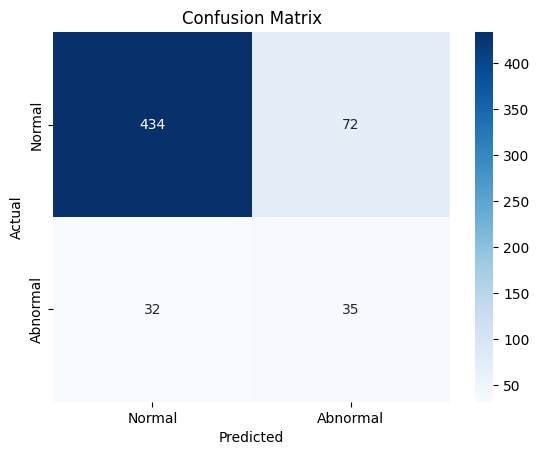

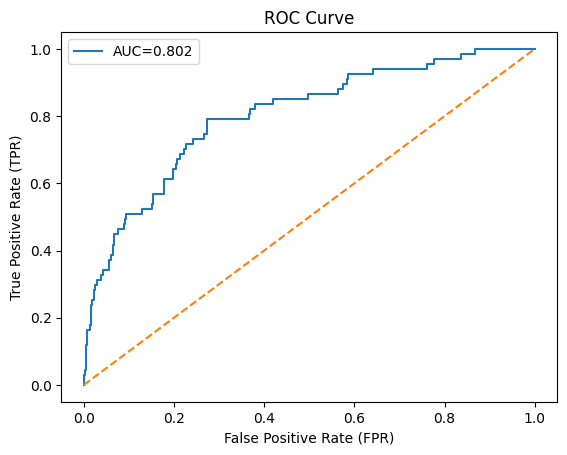


Launching Gradio app...
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aa1a42ca7cca730666.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Main
def main() -> None:
    device = get_device()
    print(f"Using device: {device}")

    print("Loading data...")
    data = load_and_prepare_dataframe(
        reports_file=CFG.reports_file,
        projections_file=CFG.projections_file,
        images_dir=CFG.images_dir,
    )

    print("Loading tokenizer...")
    tokenizer = load_tokenizer()
    print("Tokenizer loaded.")

    image_transform = build_transforms()

    train_df, val_df, test_df = split_data(
        df=data,
        random_state=CFG.random_state,
    )

    train_loader, val_loader, test_loader = build_loaders(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        tokenizer=tokenizer,
        image_transform=image_transform,
        batch_size=CFG.batch_size,
        max_len=CFG.max_len,
    )

    print("Building model...")
    model = MultimodalModel(num_classes=CFG.num_classes).to(device)

    # Freeze transformer initially
    for param in model.transformer.parameters():
        param.requires_grad = False

    # Weighted loss for imbalance
    class_weights = compute_class_weights(train_df).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_frozen)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=2
    )

    print("Training...")
    model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        device=device,
        epochs=CFG.epochs,
        patience=CFG.patience,
        unfreeze_epoch=CFG.unfreeze_epoch,
        lr_unfrozen=CFG.lr_unfrozen,
        save_path=CFG.model_save_path,
    )

    print("\nEvaluating on test set...")
    evaluate_model(model, test_loader, device)

    print("\nLaunching Gradio app...")
    interface = build_gradio_app(
        model=model,
        tokenizer=tokenizer,
        image_transform=image_transform,
        device=device,
    )
    interface.launch()


if __name__ == "__main__":
    main()